## Importing Required Libraries

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy.linalg import det, inv

##Dataset for one parameter estimation is generated using above equation where we consider random values of k and we get temperature values at 11 different points along the length of slab

# Data generation

In [ ]:
np.random.seed(42)
k_values = np.random.rand(1000) * 190 + 10
x = np.linspace(0.0,1.0,11)
print(x)
t_values = []
for k in k_values:
    temp = 1000.0*((1-x)/k+1.0/12.5)+298
    t_values.append(temp)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:
#convertint the temperature values array to CSV file
import csv

# field names
fields = ['x1', 'x2', 'x3', 'x4','x5','x6','x7','x8','x9','x10','x11']
with open('Temp_data1D.csv', 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(fields)
    write.writerows(t_values)

## Reading data for 1 parameter estimation

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

data = pd.read_csv('/content/Temp_data1D.csv')
data = pd.DataFrame(data)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094,378.0
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561,378.0
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786,378.0
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113,378.0
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479,378.0


In [ ]:
data['k'] = k_values

In [ ]:
import numpy as np

# Select the last column of the DataFrame
k = data.iloc[:, -1]

# Calculate 5% of each value in y as standard deviation
k_std = k * 0.05

k_variance = k_std ** 2

# Calculate the logarithm of the 10% variance to get log variance
data['k_log_var_prior'] = np.log(k_variance)

# Display the first few entries of the DataFrame with the new 'log_var' column
data[['k_log_var_prior']].head()

,k_log_var_prior
0,2.801445
1,4.509264
2,4.017486
3,3.644983
4,1.368392


In [ ]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,k,k_log_var_prior
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094,378.0,81.162623,2.801445
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561,378.0,190.635718,4.509264
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786,378.0,149.078849,4.017486
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113,378.0,123.745112,3.644983
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479,378.0,39.643542,1.368392


## Splitting data into independent and dependent variables

## Independent features are the values of temperature distribution along the length

In [ ]:
original_data_without_noise = data.iloc[:,:-3]
original_data_without_noise.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,390.320942,389.088848,387.856754,386.624660,385.392565,384.160471,382.928377,381.696283,380.464188,379.232094
1,383.245607,382.721046,382.196485,381.671925,381.147364,380.622803,380.098243,379.573682,379.049121,378.524561
2,384.707860,384.037074,383.366288,382.695502,382.024716,381.353930,380.683144,380.012358,379.341572,378.670786
3,386.081127,385.273015,384.464902,383.656789,382.848676,382.040564,381.232451,380.424338,379.616225,378.808113
4,403.224790,400.702311,398.179832,395.657353,393.134874,390.612395,388.089916,385.567437,383.044958,380.522479


## Dependent variable is the value of Thermal Conductivity

In [ ]:
y = data['k']
y.head()

0     81.162623
1    190.635718
2    149.078849
3    123.745112
4     39.643542
Name: k, dtype: float64

In [ ]:
y_log_var_prior = data['k_log_var_prior']
y_log_var_prior.head()

0    2.801445
1    4.509264
2    4.017486
3    3.644983
4    1.368392
Name: k_log_var_prior, dtype: float64

## Adding Noise in the temperature columns

## Adjust the value of noise standard deviation as needed for experimentation

In [ ]:
# Percentage of the standard deviation to be used for noise
percentage_std = 5 / 100

# Calculate standard deviations for each column
std_devs = original_data_without_noise.std()

# Generate noise for each element based on 5% of the column's standard deviation
noise = pd.DataFrame()
for column in original_data_without_noise.columns:
    column_noise = np.random.normal(0, std_devs[column] * percentage_std, size=original_data_without_noise.shape[0])
    noise[column] = column_noise

# Add the noise to the original data
original_data_with_noise = original_data_without_noise + noise

# Show the modified DataFrame
print(original_data_with_noise.head())

           x1          x2          x3          x4          x5          x6  \
0  390.461831  388.085359  388.411437  386.541233  385.525327  383.671866   
1  382.186889  382.661745  381.784356  381.490612  381.286062  380.351456   
2  385.009297  382.963368  382.603129  382.116882  381.220454  381.535223   
3  386.565226  385.815359  383.803960  383.006211  382.383199  382.872343   
4  403.668615  400.761136  397.870812  395.915073  394.445546  390.557656   

           x7          x8          x9         x10  
0  383.309554  381.604445  380.347693  379.195808  
1  380.101030  379.815155  379.200703  378.609512  
2  380.701495  380.038042  379.529246  378.582800  
3  381.148222  381.044387  379.431546  378.833741  
4  388.306980  385.613439  382.854055  380.399781  


Standard Deviation of each column

In [ ]:
std_devs

x1     15.856853
x2     14.271168
x3     12.685483
x4     11.099797
x5      9.514112
x6      7.928427
x7      6.342741
x8      4.757056
x9      3.171371
x10     1.585685
dtype: float64

Noise Dataframe

In [ ]:
noise

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.140889,-1.003490,0.554684,-0.083426,0.132762,-0.488605,0.381177,-0.091838,-0.116496,-0.036287
1,-1.058718,-0.059301,-0.412129,-0.181313,0.138698,-0.271347,0.002787,0.241473,0.151581,0.084951
2,0.301437,-1.073706,-0.763159,-0.578620,-0.804262,0.181293,0.018351,0.025684,0.187674,-0.087986
3,0.484098,0.542344,-0.660942,-0.650578,-0.465478,0.831780,-0.084229,0.620049,-0.184679,0.025628
4,0.443826,0.058826,-0.309020,0.257721,1.310672,-0.054739,0.217065,0.046002,-0.190903,-0.122698
...,...,...,...,...,...,...,...,...,...,...
995,-1.046570,-0.203275,0.299087,0.434352,-0.619771,0.325885,0.191067,-0.327594,0.251712,0.017169
996,-0.485037,-0.182799,-1.161448,-0.013449,0.215051,0.345740,0.329841,-0.081663,0.063427,-0.124653
997,-0.029364,-0.172323,-0.779170,0.667348,-0.169339,0.128455,-0.323121,0.271677,0.026300,-0.024377
998,-0.340369,-0.044072,-1.316492,-0.607864,0.013886,0.326692,-0.072235,0.275254,0.132720,0.030917


In [ ]:
result = pd.concat([original_data_with_noise, y, y_log_var_prior], axis=1)
result.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k,k_log_var_prior
0,390.461831,388.085359,388.411437,386.541233,385.525327,383.671866,383.309554,381.604445,380.347693,379.195808,81.162623,2.801445
1,382.186889,382.661745,381.784356,381.490612,381.286062,380.351456,380.101030,379.815155,379.200703,378.609512,190.635718,4.509264
2,385.009297,382.963368,382.603129,382.116882,381.220454,381.535223,380.701495,380.038042,379.529246,378.582800,149.078849,4.017486
3,386.565226,385.815359,383.803960,383.006211,382.383199,382.872343,381.148222,381.044387,379.431546,378.833741,123.745112,3.644983
4,403.668615,400.761136,397.870812,395.915073,394.445546,390.557656,388.306980,385.613439,382.854055,380.399781,39.643542,1.368392


## Normalizing the combined Dataframe

Getting mean and standard deviation of each column

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_and_store_params(df):
    scaler = StandardScaler()
    standardized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Storing means and scales (standard deviations)
    params = {
        'mean': scaler.mean_,
        'scale': scaler.scale_
    }
    return standardized_df, params

# Standardizing and storing parameters
standardized_df, params = standardize_and_store_params(result)
print("Standardized DataFrame:")
print(standardized_df)
print("\nStored Parameters:")
print(params)

Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.242776 -0.318661 -0.202682 -0.251064 -0.231564 -0.307002 -0.186806   
1   -0.763309 -0.699086 -0.724214 -0.704988 -0.676511 -0.725701 -0.692707   
2   -0.585766 -0.677930 -0.659779 -0.648702 -0.683397 -0.576430 -0.598029   
3   -0.487891 -0.477884 -0.565277 -0.568774 -0.561357 -0.407821 -0.527592   
4    0.587994  0.570448  0.541743  0.591409  0.704688  0.561288  0.601159   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.203227  1.263567  1.299181  1.316356  1.211850  1.319899  1.307903   
996 -0.715859 -0.696345 -0.771811 -0.678537 -0.657122 -0.636498 -0.629746   
997  0.719040  0.715618  0.665690  0.789056  0.710340  0.745570  0.677219   
998 -0.717965 -0.697861 -0.795227 -0.743167 -0.689454 -0.650132 -0.704378   
999 -0.397253 -0.335753 -0.361805 -0.513114 -0.321855 -0.364931 -0.405284   

           x8        x9       x10         k  k_log_

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler = StandardScaler()

# Normalize the DataFrame and create a new DataFrame
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

print("\nStandardized DataFrame:")
print(result)


Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.242776 -0.318661 -0.202682 -0.251064 -0.231564 -0.307002 -0.186806   
1   -0.763309 -0.699086 -0.724214 -0.704988 -0.676511 -0.725701 -0.692707   
2   -0.585766 -0.677930 -0.659779 -0.648702 -0.683397 -0.576430 -0.598029   
3   -0.487891 -0.477884 -0.565277 -0.568774 -0.561357 -0.407821 -0.527592   
4    0.587994  0.570448  0.541743  0.591409  0.704688  0.561288  0.601159   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.203227  1.263567  1.299181  1.316356  1.211850  1.319899  1.307903   
996 -0.715859 -0.696345 -0.771811 -0.678537 -0.657122 -0.636498 -0.629746   
997  0.719040  0.715618  0.665690  0.789056  0.710340  0.745570  0.677219   
998 -0.717965 -0.697861 -0.795227 -0.743167 -0.689454 -0.650132 -0.704378   
999 -0.397253 -0.335753 -0.361805 -0.513114 -0.321855 -0.364931 -0.405284   

           x8        x9       x10         k  k_log

In [ ]:
result.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k,k_log_var_prior
0,-0.242776,-0.318661,-0.202682,-0.251064,-0.231564,-0.307002,-0.186806,-0.269009,-0.283061,-0.269547,-0.396301,-0.044916
1,-0.763309,-0.699086,-0.724214,-0.704988,-0.676511,-0.725701,-0.692707,-0.645311,-0.644549,-0.639784,1.576957,1.138607
2,-0.585766,-0.677930,-0.659779,-0.648702,-0.683397,-0.576430,-0.598029,-0.598436,-0.541005,-0.656652,0.827893,0.797804
3,-0.487891,-0.477884,-0.565277,-0.568774,-0.561357,-0.407821,-0.527592,-0.386793,-0.571796,-0.498187,0.371251,0.539658
4,0.587994,0.570448,0.541743,0.591409,0.704688,0.561288,0.601159,0.574114,0.506849,0.490746,-1.144685,-1.038026


## Splitting the dataset into train and test

In [ ]:
x_train = result.iloc[:800,:-2]
x_test = result.iloc[800:,:-2]
x_train.shape, x_test.shape

y_train = result.iloc[:800,-2]
y_test = result.iloc[800:,-2]
y_train.shape, y_test.shape

((800,), (200,))

In [ ]:
y_train_log_var = result.iloc[:800,-1]
y_test_log_var = result.iloc[800:,-1]
y_train_log_var.shape, y_test_log_var.shape

((800,), (200,))

In [ ]:
training_feature = x_train
training_score_k = y_train

testing_feature_sk = x_test
testing_score = y_test

#**VAE**

## Reparameterization Trick Function

$\mu_z + \epsilon \sigma_z$

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]
print(original_dim)

10


original_dim: Number of measuring locations

In [ ]:
input_shape_x = (original_dim, )
input_shape_r = (1, )
input_shape_log_var = (1,)

In [ ]:
intermediate_dim_1 = 8 # 1st layer
intermediate_dim_2 = 5 # 2nd Layer
intermediate_dim_3 = 3 # 3rd Layer
batch_size = 32
latent_dim = 1

In [ ]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model

### **CVAE Model**

##### **Encoder**

In [ ]:
input_shape_r = (1, )
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_log_var = Input(shape=input_shape_log_var, name='log_var_input')

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# posterior on Y; probablistic regressor
r_mean = Dense(1, name='r_mean')(inter_x3)
r_log_var = Dense(1, name='r_log_var')(inter_x3)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

# instantiate encoder model
encoder = Model([inputs_x], [z_mean, z_log_var, z, r_mean, r_log_var, r], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 10)]                 0         []                            
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    88        ['encoder_input[0][0]']       
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1[0][0]
 nse)                                                               ']                            
                                                                                            

**Generator**

In [ ]:
# latent generator (simplified)
generator_input = Input(shape=(1,), name='generator_input')
pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(generator_input)
pz_log_var = Dense(1, name='pz_log_var')(generator_input)

# instantiate generator model
generator = Model(generator_input, [pz_mean,pz_log_var], name='generator')
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 generator_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 pz_mean (Dense)             (None, 1)                    2         ['generator_input[0][0]']     
                                                                                                  
 pz_log_var (Dense)          (None, 1)                    2         ['generator_input[0][0]']     
                                                                                                  
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.0

**Decoder**

In [ ]:
# decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Decoder layers - mirroring the encoder
decoder_inter_x1 = Dense(intermediate_dim_3, activation='tanh', name='decoder_intermediate_1')(latent_inputs)
decoder_inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='decoder_intermediate_2')(decoder_inter_x1)
decoder_inter_x3 = Dense(intermediate_dim_1, activation='tanh', name='decoder_intermediate_3')(decoder_inter_x2)

# Output layer - mapping back to original input space
outputs = Dense(original_dim, activation='linear', name='decoder_output')(decoder_inter_x3)

# Instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1)]               0         
                                                                 
 decoder_intermediate_1 (De  (None, 3)                 6         
 nse)                                                            
                                                                 
 decoder_intermediate_2 (De  (None, 5)                 20        
 nse)                                                            
                                                                 
 decoder_intermediate_3 (De  (None, 8)                 48        
 nse)                                                            
                                                                 
 decoder_output (Dense)      (None, 10)                90        
                                                           

## CVAE Model Summary

In [ ]:
# instantiate VAE model
pz_mean,pz_log_var = generator(encoder([inputs_x])[5])
outputs = decoder(encoder([inputs_x])[2])
vae = Model([inputs_x,inputs_r, inputs_log_var], [outputs, pz_mean,pz_log_var], name='vae_mlp')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 10)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 1),                  167       ['encoder_input[0][0]',       
                              (None, 1),                             'encoder_input[0][0]']       
                              (None, 1),                                                          
                              (None, 1),                                                          
                              (None, 1),                                                          
                              (None, 1)]                                                    

#### **Loss Function of CVAE**

Loss function is the Customized loss function consisting of
Reconstruction Loss : MSE Loss between the inputs to encoder and outputs from decoder
KL Divergence loss : Between main latent space distribution and output from generator
Label Loss : Also a KL Divergence loss between latent space distribution of the estimated variable and prior distribution

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.losses import MeanSquaredError

# Define your mean squared error loss function
mse = MeanSquaredError()

# Compute reconstruction loss
reconstruction_loss = mse(inputs_x, outputs)

# # Compute KL divergence loss
kl_loss = 1 + z_log_var - pz_log_var - tf.divide(tf.square(z_mean - pz_mean), tf.exp(pz_log_var)) - tf.divide(tf.exp(z_log_var), tf.exp(pz_log_var))
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

label_loss = 1 + inputs_log_var - r_log_var - tf.divide(tf.square(r_mean - inputs_r), tf.exp(r_log_var)) - tf.divide(tf.exp(inputs_log_var), tf.exp(r_log_var))
label_loss = -0.5 * K.sum(label_loss, axis=-1)

# Compute total VAE loss
vae_loss = K.mean(reconstruction_loss + K.abs(kl_loss) + K.abs(label_loss))

# Assuming 'vae' is your model instance
vae.add_loss(vae_loss)

## Setting the Optimizer and the learning rate for the VAE Model

In [ ]:
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)

## Setting maximum epochs as 1000 and patience in early stopping as 50

Epoch 1/1000
22/25 [=========================>....] - ETA: 0s - loss: 3.0577

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 8s 52ms/step - loss: 2.9347 - val_loss: 2.6444
Epoch 2/1000
20/25 [=======================>......] - ETA: 0s - loss: 2.5138

25/25 [==============================] - 0s 19ms/step - loss: 2.4090 - val_loss: 2.4170
Epoch 3/1000
25/25 [==============================] - ETA: 0s - loss: 2.4020

25/25 [==============================] - 0s 20ms/step - loss: 2.4020 - val_loss: 2.1561
Epoch 4/1000
21/25 [========================>.....] - ETA: 0s - loss: 2.1955

25/25 [==============================] - 0s 19ms/step - loss: 2.1567 - val_loss: 1.9482
Epoch 5/1000
25/25 [==============================] - 0s 13ms/step - loss: 1.9668 - val_loss: 1.9512
Epoch 6/1000
23/25 [==========================>...] - ETA: 0s - loss: 1.9684

25/25 [==============================] - 1s 32ms/step - loss: 1.9546 - val_loss: 1.8427
Epoch 7/1000
25/25 [==============================] - 0s 17ms/step - loss: 1.8740 - val_loss: 1.8451
Epoch 8/1000
25/25 [==============================] - ETA: 0s - loss: 1.7447

25/25 [==============================] - 1s 38ms/step - loss: 1.7447 - val_loss: 1.7153
Epoch 9/1000
23/25 [==========================>...] - ETA: 0s - loss: 1.7340

25/25 [==============================] - 1s 60ms/step - loss: 1.6829 - val_loss: 1.6861
Epoch 10/1000
21/25 [========================>.....] - ETA: 0s - loss: 1.4906

25/25 [==============================] - 0s 14ms/step - loss: 1.5385 - val_loss: 1.5997
Epoch 11/1000
22/25 [=========================>....] - ETA: 0s - loss: 1.4586

25/25 [==============================] - 1s 24ms/step - loss: 1.4275 - val_loss: 1.5619
Epoch 12/1000
19/25 [=====================>........] - ETA: 0s - loss: 1.5472

25/25 [==============================] - 0s 18ms/step - loss: 1.5149 - val_loss: 1.5316
Epoch 13/1000
21/25 [========================>.....] - ETA: 0s - loss: 1.3903

25/25 [==============================] - 0s 18ms/step - loss: 1.3452 - val_loss: 1.5123
Epoch 14/1000
19/25 [=====================>........] - ETA: 0s - loss: 1.3210

25/25 [==============================] - 0s 15ms/step - loss: 1.3598 - val_loss: 1.3196
Epoch 15/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.2884 - val_loss: 1.4743
Epoch 16/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.3190 - val_loss: 1.4061
Epoch 17/1000
20/25 [=======================>......] - ETA: 0s - loss: 1.2204

25/25 [==============================] - 0s 16ms/step - loss: 1.2284 - val_loss: 1.2084
Epoch 18/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.2852 - val_loss: 1.3598
Epoch 19/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.3336 - val_loss: 1.3375
Epoch 20/1000
25/25 [==============================] - 0s 9ms/step - loss: 1.3080 - val_loss: 1.3091
Epoch 21/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.2046 - val_loss: 1.3023
Epoch 22/1000
25/25 [==============================] - 0s 11ms/step - loss: 1.2075 - val_loss: 1.3327
Epoch 23/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.1801 - val_loss: 1.3616
Epoch 24/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.1377 - val_loss: 1.2666
Epoch 25/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.1603 - val_loss: 1.4089
Epoch 26/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.1278 - val_loss: 1.230

25/25 [==============================] - 0s 16ms/step - loss: 1.0810 - val_loss: 1.1839
Epoch 30/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.0989 - val_loss: 1.2498
Epoch 31/1000
19/25 [=====================>........] - ETA: 0s - loss: 1.0130

25/25 [==============================] - 0s 9ms/step - loss: 1.0275 - val_loss: 1.0951
Epoch 32/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.1254 - val_loss: 1.1715
Epoch 33/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0520 - val_loss: 1.1559
Epoch 34/1000
17/25 [===================>..........] - ETA: 0s - loss: 1.0810

25/25 [==============================] - 0s 9ms/step - loss: 1.1091 - val_loss: 1.0664
Epoch 35/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9903 - val_loss: 1.1833
Epoch 36/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0139 - val_loss: 1.1387
Epoch 37/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0226 - val_loss: 1.1350
Epoch 38/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0047 - val_loss: 1.0671
Epoch 39/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0673 - val_loss: 1.1072
Epoch 40/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0045 - val_loss: 1.0870
Epoch 41/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0634 - val_loss: 1.1133
Epoch 42/1000
16/25 [==================>...........] - ETA: 0s - loss: 1.0942

25/25 [==============================] - 0s 9ms/step - loss: 1.0215 - val_loss: 1.0514
Epoch 43/1000
18/25 [====================>.........] - ETA: 0s - loss: 0.9610

25/25 [==============================] - 0s 9ms/step - loss: 0.9771 - val_loss: 1.0058
Epoch 44/1000
18/25 [====================>.........] - ETA: 0s - loss: 0.9220

25/25 [==============================] - 0s 9ms/step - loss: 0.9576 - val_loss: 0.9784
Epoch 45/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9511 - val_loss: 0.9949
Epoch 46/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9438 - val_loss: 1.0012
Epoch 47/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9468 - val_loss: 1.0408
Epoch 48/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.9615 - val_loss: 0.9984
Epoch 49/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.9512 - val_loss: 1.0041
Epoch 50/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9277 - val_loss: 0.9884
Epoch 51/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.9126 - val_loss: 1.0590
Epoch 52/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9192 - val_loss: 1.0042
Epoch 53/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9397 - val_loss: 1.0007
Epoc

25/25 [==============================] - 0s 9ms/step - loss: 0.9432 - val_loss: 0.9668
Epoch 55/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9137 - val_loss: 0.9740
Epoch 56/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.9151 - val_loss: 1.0322
Epoch 57/1000
25/25 [==============================] - ETA: 0s - loss: 0.9028

25/25 [==============================] - 1s 29ms/step - loss: 0.9028 - val_loss: 0.9258
Epoch 58/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.8377

25/25 [==============================] - 1s 25ms/step - loss: 0.8390 - val_loss: 0.9002
Epoch 59/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.8282 - val_loss: 0.9596
Epoch 60/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.8594 - val_loss: 0.9113
Epoch 61/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.8516 - val_loss: 0.9375
Epoch 62/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.8178 - val_loss: 0.9854
Epoch 63/1000
25/25 [==============================] - ETA: 0s - loss: 0.8030

25/25 [==============================] - 1s 25ms/step - loss: 0.8030 - val_loss: 0.8702
Epoch 64/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.7966

25/25 [==============================] - 1s 26ms/step - loss: 0.7872 - val_loss: 0.8685
Epoch 65/1000
21/25 [========================>.....] - ETA: 0s - loss: 0.7978

25/25 [==============================] - 1s 25ms/step - loss: 0.7882 - val_loss: 0.8246
Epoch 66/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.7857 - val_loss: 0.8948
Epoch 67/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.8178 - val_loss: 0.8678
Epoch 68/1000
18/25 [====================>.........] - ETA: 0s - loss: 0.8032

25/25 [==============================] - 0s 15ms/step - loss: 0.8071 - val_loss: 0.8227
Epoch 69/1000
17/25 [===================>..........] - ETA: 0s - loss: 0.8146

25/25 [==============================] - 0s 15ms/step - loss: 0.8015 - val_loss: 0.8091
Epoch 70/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.7781 - val_loss: 0.8698
Epoch 71/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.7826 - val_loss: 0.8202
Epoch 72/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.7634

25/25 [==============================] - 0s 16ms/step - loss: 0.7608 - val_loss: 0.8035
Epoch 73/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7993 - val_loss: 0.8772
Epoch 74/1000
17/25 [===================>..........] - ETA: 0s - loss: 0.8013

25/25 [==============================] - 0s 9ms/step - loss: 0.7910 - val_loss: 0.7958
Epoch 75/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7989 - val_loss: 0.9025
Epoch 76/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.7732 - val_loss: 0.7960
Epoch 77/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7662 - val_loss: 0.8043
Epoch 78/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.7455 - val_loss: 0.8587
Epoch 79/1000
18/25 [====================>.........] - ETA: 0s - loss: 0.7479

25/25 [==============================] - 0s 8ms/step - loss: 0.7726 - val_loss: 0.6912
Epoch 80/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7642 - val_loss: 0.7991
Epoch 81/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7181 - val_loss: 0.8144
Epoch 82/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7441 - val_loss: 0.7222
Epoch 83/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7122 - val_loss: 0.8477
Epoch 84/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7220 - val_loss: 0.7569
Epoch 85/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7684 - val_loss: 0.7666
Epoch 86/1000
18/25 [====================>.........] - ETA: 0s - loss: 0.6687

25/25 [==============================] - 0s 8ms/step - loss: 0.6625 - val_loss: 0.6723
Epoch 87/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7301 - val_loss: 0.7967
Epoch 88/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6990 - val_loss: 0.7796
Epoch 89/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7088 - val_loss: 0.6796
Epoch 90/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6885 - val_loss: 0.7652
Epoch 91/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7492 - val_loss: 0.6933
Epoch 92/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7055 - val_loss: 0.7019
Epoch 93/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6864 - val_loss: 0.7850
Epoch 94/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7332 - val_loss: 0.7552
Epoch 95/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6707 - val_loss: 0.7455
Epoc

25/25 [==============================] - 0s 9ms/step - loss: 0.6520 - val_loss: 0.6429
Epoch 113/1000
18/25 [====================>.........] - ETA: 0s - loss: 0.6593

25/25 [==============================] - 0s 8ms/step - loss: 0.6705 - val_loss: 0.6120
Epoch 114/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6732 - val_loss: 0.6899
Epoch 115/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6549 - val_loss: 0.6621
Epoch 116/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6795 - val_loss: 0.7532
Epoch 117/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6915 - val_loss: 0.6387
Epoch 118/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6753 - val_loss: 0.6798
Epoch 119/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6772 - val_loss: 0.7061
Epoch 120/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6617 - val_loss: 0.6473
Epoch 121/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6450 - val_loss: 0.6832
Epoch 122/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6383 - val_loss: 0.

25/25 [==============================] - 0s 15ms/step - loss: 0.6356 - val_loss: 0.5958
Epoch 144/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6562 - val_loss: 0.6546
Epoch 145/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6400 - val_loss: 0.6521
Epoch 146/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6189 - val_loss: 0.6942
Epoch 147/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6377 - val_loss: 0.6386
Epoch 148/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6110 - val_loss: 0.6461
Epoch 149/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.6245 - val_loss: 0.7055
Epoch 150/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.6209 - val_loss: 0.6573
Epoch 151/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.6533 - val_loss: 0.6179
Epoch 152/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.6542 - val_l

25/25 [==============================] - 1s 26ms/step - loss: 0.6439 - val_loss: 0.5778
Epoch 161/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6486 - val_loss: 0.6605
Epoch 162/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6235 - val_loss: 0.5869
Epoch 163/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6599 - val_loss: 0.6543
Epoch 164/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.6525 - val_loss: 0.6255
Epoch 165/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6703 - val_loss: 0.6943
Epoch 166/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6209 - val_loss: 0.7126
Epoch 167/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6246 - val_loss: 0.6001
Epoch 168/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6136 - val_loss: 0.7147
Epoch 169/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6437 - val_los

25/25 [==============================] - 0s 9ms/step - loss: 0.6108 - val_loss: 0.5660
Epoch 209/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.5798 - val_loss: 0.6400
Epoch 210/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6523 - val_loss: 0.6387
Epoch 211/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6029 - val_loss: 0.6448
Epoch 212/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6171 - val_loss: 0.5973
Epoch 213/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6199 - val_loss: 0.6036
Epoch 214/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.5926 - val_loss: 0.6853
Epoch 215/1000
17/25 [===================>..........] - ETA: 0s - loss: 0.5979

25/25 [==============================] - 0s 9ms/step - loss: 0.5882 - val_loss: 0.5351
Epoch 216/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6178 - val_loss: 0.5861
Epoch 217/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6278 - val_loss: 0.5477
Epoch 218/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.5840 - val_loss: 0.5972
Epoch 219/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.5777 - val_loss: 0.7242
Epoch 220/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.5913 - val_loss: 0.5466
Epoch 221/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.5935 - val_loss: 0.6841
Epoch 222/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6570 - val_loss: 0.5936
Epoch 223/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6158 - val_loss: 0.5937
Epoch 224/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6120 - val_loss: 0.

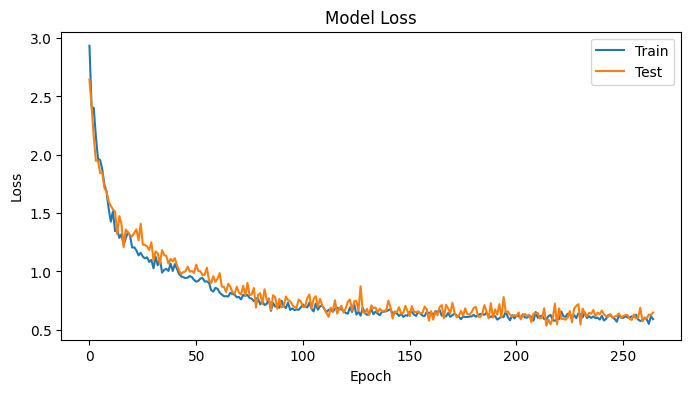

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_cvae.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model with validation data and callbacks
history = vae.fit([x_train, y_train, y_train_log_var], x_train,
                  epochs=1000,
                  batch_size=32,
                  validation_data=([x_test, y_test, y_test_log_var], x_test),
                  callbacks=[early_stopping, model_checkpoint])

# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Plotting the results for Training Data

25/25 [==============================] - 0s 2ms/step
Mean squared error: 0.023
R2 Variance score: 0.977


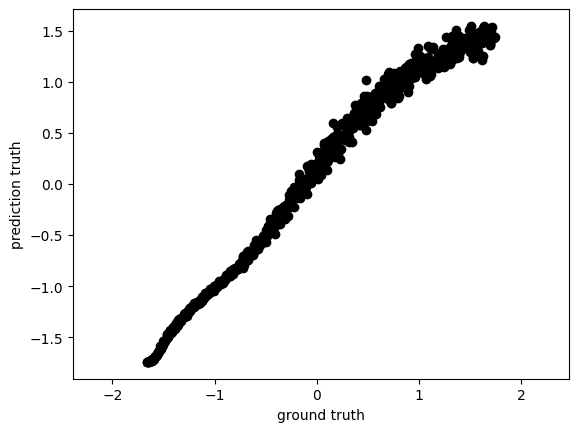

In [ ]:
[z_mean, z_log_var, z, r_mean, r_log_var, r] = encoder.predict([x_train],batch_size=batch_size)

## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_train, r_mean))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_train, r_mean))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_train, r_mean,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

## Plotting the results for test data

7/7 [==============================] - 0s 2ms/step
Mean squared error: 0.021
R2 Variance score: 0.978


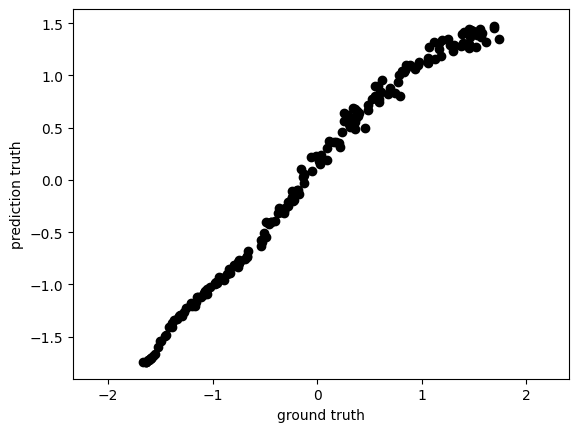

In [ ]:
[z_mean_t, z_log_var_t, z_t, r_mean_t, r_log_var_t, r_t] = encoder.predict([x_test],batch_size=batch_size)

## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, r_mean_t))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_test, r_mean_t))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_test, r_mean_t,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [ ]:
# Combine the training data and their encoded representations
train_combined = np.hstack((x_train, r_mean, r_log_var))

# Combine the test data and their encoded representations
test_combined = np.hstack((x_test, r_mean_t, r_log_var_t))

# Concatenate the training and test datasets row-wise
combined_data = np.vstack((train_combined, test_combined))

# Inverse transform to original scale
original_scale_data = scaler.inverse_transform(combined_data)

# Optionally convert to DataFrame for better readability and further processing
df = pd.DataFrame(original_scale_data, columns=[result.columns])

In [ ]:
# Rename the 'k' and 'k_log_var_prior' columns
df.rename(columns={'k': 'k_pred', 'k_log_var_prior': 'k_std_dev_pred'}, inplace=True)

# Convert log variance to standard deviation
# Since log variance is log(sigma^2), standard deviation sigma = sqrt(exp(log(sigma^2)))
df['k_std_dev_pred'] = np.sqrt(np.exp(df['k_std_dev_pred']))

df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k_pred,k_std_dev_pred
0,390.461831,388.085359,388.411437,386.541233,385.525327,383.671866,383.309554,381.604445,380.347693,379.195808,82.541914,3.639206
1,382.186889,382.661745,381.784356,381.490612,381.286062,380.351456,380.101030,379.815155,379.200703,378.609512,179.929222,7.076273
2,385.009297,382.963368,382.603129,382.116882,381.220454,381.535223,380.701495,380.038042,379.529246,378.582800,164.233284,6.368695
3,386.565226,385.815359,383.803960,383.006211,382.383199,382.872343,381.148222,381.044387,379.431546,378.833741,135.421336,5.108699
4,403.668615,400.761136,397.870812,395.915073,394.445546,390.557656,388.306980,385.613439,382.854055,380.399781,38.715477,2.064719
...,...,...,...,...,...,...,...,...,...,...,...,...
995,413.448989,410.642728,407.495535,403.981243,399.277565,396.573664,392.789290,388.621074,385.550824,381.666725,28.829581,1.504930
996,382.941206,382.700819,381.179546,381.784921,381.470797,381.058861,380.500338,379.546210,379.148675,378.417971,178.776675,7.039151
997,405.751855,402.830775,399.445806,398.114202,394.499393,392.019065,388.789366,386.606043,383.582544,380.753745,37.302813,1.998251
998,382.907732,382.679219,380.881989,381.065807,381.162747,380.950743,380.027006,379.849684,379.182341,378.555727,181.109103,7.018688


Mean squared error on original scale: 8.021
R2 Variance score on original scale: 0.978


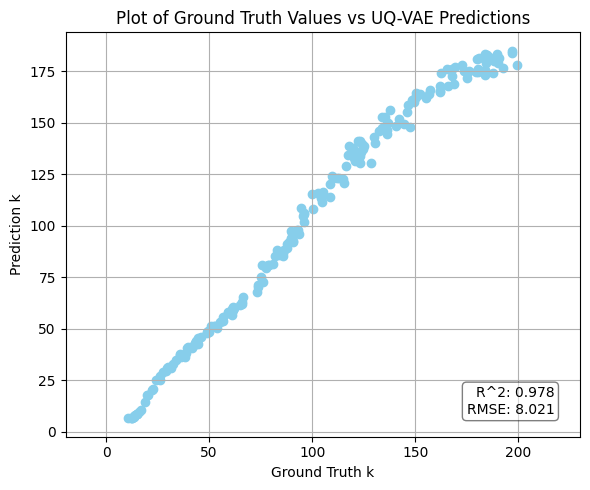

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming 'data' and 'combined_original' are previously defined pandas DataFrame and numpy array, respectively.

# Calculate metrics
rmse = np.sqrt(mean_squared_error(data.iloc[800:, -2], df.iloc[800:, -2]))
r2 = r2_score(data.iloc[800:, -2], df.iloc[800:, -2])

# Print metrics
print("Mean squared error on original scale: %.3f" % rmse)
print('R2 Variance score on original scale: %.3f' % r2)

# Plot Prediction vs. Ground-truth Y on original scale
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(data.iloc[800:, -2], df.iloc[800:, -2], color='skyblue')
ax.set_xlabel('Ground Truth k')
ax.set_ylabel('Prediction k')
ax.axis('equal')
ax.grid(True)
plt.title('Plot of Ground Truth Values vs UQ-VAE Predictions')

# Adding RMSE and R^2 text with bounding box
textstr = f'R^2: {r2:.3f}\nRMSE: {rmse:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

## Comparison between CVAE Results and MCMC

In [ ]:
import numpy as np

# Define an array of different k values
k_values = data.iloc[:,-2]

# Define a 2D array of different T values
T_values_2d = df.iloc[:,:-2]
T_values_2d = df.iloc[:,:-2].to_numpy()

# Initialize lists to store km and sq values for each set
km_list = []
sq_list = []

# Problem Parameters
q = 1000
L = 1.0
TL = 378
x = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
Nm = len(x)

# Priors
Ns = 10

for k, T_values in zip(k_values, T_values_2d):
        sigma_k = 0.05 * k
        kmin = k - sigma_k
        kmax = k + sigma_k
        ks = np.linspace(kmin, kmax, Ns)

        Tsim = np.zeros((Ns, Nm))
        P1 = np.zeros(Ns)
        P2 = np.zeros(Ns)
        P3a = np.zeros(Ns)

        for i in range(Ns):
            Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
            e = Tsim[i, :] - T_values
            A = np.sum(e**2)
            B = (ks[i] - k)**2 / sigma_k**2
            S = A + B
            f = -0.5 * S
            P1[i] = np.exp(f)
            P2[i] = ks[i] * np.exp(f)
            P3a[i] = ks[i]**2 * np.exp(f)

        Den = np.sum(P1)
        km = np.sum(P2) / Den
        vark = np.sum(P3a) / Den - km**2
        sq = np.sqrt(vark)

        # Store km and sq values in the lists
        km_list.append(km)
        sq_list.append(sq)

# km_list and sq_list now contain the results for each set of T values and the associated k value
# You will have km and sq values for each combination of T values and k value
for km, sq in zip(km_list, sq_list):
    print(f"km: {km}, sq: {sq}")

km: 81.51028819886541, sq: 2.1011673818265866
km: 191.8970457075179, sq: 5.399891588852809
km: 150.6937474010587, sq: 4.062408146979404
km: 123.59466691746965, sq: 3.457057710564164
km: 39.255546940660686, sq: 0.7173147754362054
km: 39.83479022946658, sq: 0.7326264438909561
km: 20.983811002924334, sq: 0.2195516220518901
km: 175.50448619258114, sq: 4.950295923143815
km: 125.08785664294557, sq: 3.408900498790454
km: 144.36543814168388, sq: 4.094853981344607
km: 13.952664331954539, sq: 0.09832070069088868
km: 195.0865424476663, sq: 5.559199016100546
km: 168.12998758255955, sq: 4.8121983820639125
km: 50.91981125277799, sq: 1.0600461230921332
km: 44.94013315888609, sq: 0.8850067577098989
km: 45.035853106083295, sq: 0.9032848712893435
km: 67.35031416514528, sq: 1.6593617211352292
km: 110.63175103985328, sq: 2.946049209938483
km: 92.34856544706042, sq: 2.4559985577978574
km: 65.42391114275385, sq: 1.5942445165998982
km: 125.10432534070205, sq: 3.4598961509184605
km: 36.52009590391476, sq: 0.6

In [ ]:
import pandas as pd
df['MCMC pred'] = km_list
df['MCMC pred standard deviation'] = sq_list
df['Ground Truth'] = data.iloc[:,-2]
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,k_pred,k_std_dev_pred,MCMC pred,MCMC pred standard deviation,Ground Truth
0,390.461831,388.085359,388.411437,386.541233,385.525327,383.671866,383.309554,381.604445,380.347693,379.195808,82.541914,3.639206,81.510288,2.101167,81.162623
1,382.186889,382.661745,381.784356,381.490612,381.286062,380.351456,380.101030,379.815155,379.200703,378.609512,179.929222,7.076273,191.897046,5.399892,190.635718
2,385.009297,382.963368,382.603129,382.116882,381.220454,381.535223,380.701495,380.038042,379.529246,378.582800,164.233284,6.368695,150.693747,4.062408,149.078849
3,386.565226,385.815359,383.803960,383.006211,382.383199,382.872343,381.148222,381.044387,379.431546,378.833741,135.421336,5.108699,123.594667,3.457058,123.745112
4,403.668615,400.761136,397.870812,395.915073,394.445546,390.557656,388.306980,385.613439,382.854055,380.399781,38.715477,2.064719,39.255547,0.717315,39.643542


In [ ]:
# Save df_2 to CSV
df.to_csv('df.csv', index=False)